In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_profile
from mmctools.helper_functions import calc_wind, T_to_Tv, theta

Define some physical constants

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT profile assimilation + obs study: Assess Amarillo sounding
written by [Dries Allaerts](mailto:dries.allaerts@nrel.gov)

Assess Amarillo sounding data which is used to specify the initial potential temperature profile. This notebook depends on:
- WRF data, generated in `wrf_to_sowfa.ipynb`,
- TTU tower data, generated in `process_TTU_tower.ipynb`

Main directories on Eagle

In [6]:
datadir = '/projects/mmc/dallaert/profile_assimilation_obs/'
referencedir = '/projects/mmc/dallaert/referenceData/'

## Load observation data

In [7]:
all_data = 'TTU_obs_QC_20131108.csv'

In [8]:
df = pd.read_csv(os.path.join(referencedir,all_data),parse_dates=True,index_col=['datetime','height'])

In [9]:
df.head()

t_index  scan_type      wspd        wdir  \
datetime            height                                             
2013-11-08 12:00:00 0.9         0.0       -1.0  1.225746  219.005685   
                    2.4         0.0       -1.0  1.772110  225.353123   
                    4.0         0.0       -1.0  2.046332  229.267605   
                    10.1        0.0       -1.0  2.979477  233.780026   
                    16.8        0.0       -1.0  3.944645  239.036134   

                                   u         v  
datetime            height                      
2013-11-08 12:00:00 0.9     0.771481  0.952507  
                    2.4     1.260770  1.245325  
                    4.0     1.550640  1.335287  
                    10.1    2.403706  1.760534  
                    16.8    3.382502  2.029510

In [10]:
df = df.xs('2013-11-08 12:00:00',level='datetime')

In [11]:
radar_scan0 = df.loc[df['scan_type']==0].copy()
radar_scan1 = df.loc[df['scan_type']==1].copy()

## Load Amarillo sounding data

Load sounding data from Amarillo airport observation station (data downloaded from http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=11&FROM=0800&TO=1000&STNM=72363)

In [12]:
datetime = '2013-11-08 12:00:00'
soundingdata = 'sounding.AMA/AMA_'+datetime.replace(' ','_')
ama_sounding = np.loadtxt(referencedir+soundingdata,skiprows=8)

In [13]:
zsurface = 1099
knot_to_mpers = 0.514444

In [14]:
data = {}
data['height'] = ama_sounding[:,1]-zsurface
data['thetav'] = ama_sounding[:,10]
data['wspd'] = ama_sounding[:,7] * knot_to_mpers
data['wdir'] = ama_sounding[:,6]
ama = pd.DataFrame(data=data)
ama['datetime'] = pd.to_datetime(datetime)
ama.set_index(['datetime','height'],inplace=True)

In [15]:
ama.head()

thetav       wspd   wdir
datetime            height                          
2013-11-08 12:00:00 0.0      287.4   8.745548  215.0
                    54.0     288.9  10.288880  217.0
                    267.0    295.1  16.462208  224.0
                    343.0    296.2  18.519984  227.0
                    425.0    298.4  21.092204  230.0

## Load TTU tower data

Load tower data for surface boundary conditions. The dataset is created within the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment)

In [16]:
towerdata = 'TTU_tilt_corrected_20131108-09_10min.csv'

In [17]:
tower = pd.read_csv(os.path.join(referencedir,towerdata),parse_dates=True,index_col=['datetime','height'])

In [18]:
tower.head()

RH        T          Ts           p       theta  \
datetime   height                                                        
2013-11-08 0.9     26.186  284.794  289.410000  908.547754  292.713920   
           2.4     25.810  284.932  290.979994  908.723508  292.839558   
           4.0     25.380  285.166  287.520000  908.215548  293.126923   
           10.1    25.264  285.298  287.250000  907.611414  293.318423   
           16.8    24.934  285.414  287.610000  907.307654  293.465778   

                       thetas         u         v         w      wspd  ...  \
datetime   height                                                      ...   
2013-11-08 0.9     297.458288 -0.138929  2.637817  0.074016  2.641473  ...   
           2.4     299.055399 -0.601111  2.783204  0.487330  2.847378  ...   
           4.0     295.546639  0.416792  4.043940  0.295800  4.065362  ...   
           10.1    295.325299 -0.276479  5.227110 -0.418065  5.234417  ...   
           16.8    295.723729  0.034364  5.908367 -0.173836  5.908467  ...   

                         vv        ww   uv   vw   uw   Tw  thetaw   u*  \
datetime   height                                                        
2013-11-08 0.9     0.015000  0.008343  0.0  0.0  0.0  0.0     0.0  0.0   
           2.4     0.165325  0.078520  0.0  0.0  0.0  0.0     0.0  0.0   
           4.0     0.269958  0.003119  0.0  0.0  0.0  0.0     0.0  0.0   
           10.1    0.027879  0.221537  0.0  0.0  0.0  0.0     0.0  0.0   
           16.8    0.054370  0.019302  0.0  0.0  0.0  0.0     0.0  0.0   

                        TKE        TI  
datetime   height                      
2013-11-08 0.9     0.012876  0.048324  
           2.4     0.289067  0.126433  
           4.0     0.141290  0.117591  
           10.1    0.127415  0.032939  
           16.8    0.041629  0.040432  

[5 rows x 22 columns]

In [19]:
tower.columns

Index(['RH', 'T', 'Ts', 'p', 'theta', 'thetas', 'u', 'v', 'w', 'wspd', 'wdir',
       'uu', 'vv', 'ww', 'uv', 'vw', 'uw', 'Tw', 'thetaw', 'u*', 'TKE', 'TI'],
      dtype='object')

In [20]:
tower['Tv'] = T_to_Tv(tower['T'],p=tower['p'],RH=tower['RH'])
tower['thetav'] = theta(tower['Tv'],tower['p'])

## Load WRF data

In [21]:
WRFdata = 'WRF_20131108-09.nc'
wrf = xarray.open_dataset(os.path.join(referencedir,WRFdata)).to_dataframe()

In [22]:
# Convert to standard names
wrf.rename({'U':'u','V':'v','W':'w','UST':'u*','theta':'thetav'},
           axis='columns',inplace=True)

In [23]:
# Compute wind speed and wind direction
wrf['wspd'], wrf['wdir'] = calc_wind(wrf)

In [24]:
wrf.head()

U10      V10          T2         TSK      u*  \
Time       height                                                      
2013-11-08 0.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           5.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           10.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           15.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           20.0    0.476012  4.92231  284.730592  282.509581  0.0001   

                           PSFC  HFX   LH  MUU  MUV  ...  RV_TEND_PGF  \
Time       height                                    ...                
2013-11-08 0.0     91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           5.0     91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           10.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           15.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           20.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   

                   RV_TEND_COR  RV_TEND_PHYS  T_TEND_ADV   wt   L0  \
Time       height                                                    
2013-11-08 0.0             NaN           NaN         NaN  0.0 -inf   
           5.0             NaN           NaN         NaN  0.0 -inf   
           10.0            NaN           NaN         NaN  0.0 -inf   
           15.0            NaN           NaN         NaN  0.0 -inf   
           20.0            NaN           NaN         NaN  0.0 -inf   

                      thetaSK      theta2      wspd        wdir  
Time       height                                                
2013-11-08 0.0     290.149435  292.430509  0.000000  180.000000  
           5.0     290.149435  292.430509  5.078049  185.549135  
           10.0    290.149435  292.430509  5.212031  185.580797  
           15.0    290.149435  292.430509  5.346031  185.610835  
           20.0    290.149435  292.430509  5.420783  185.593014  

[5 rows x 32 columns]

# Plot sounding data

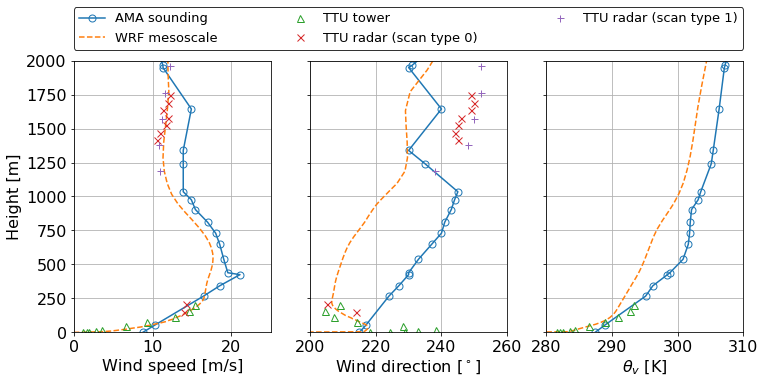

In [25]:
fig,ax = plot_profile(
    datasets={
        'AMA sounding':ama,
        'WRF mesoscale':wrf.xs('2013-11-08 12:00:00',level='Time'),
        'TTU tower':tower.xs('2013-11-08 12:00:00',level='datetime'),
        'TTU radar (scan type 0)':radar_scan0,
        'TTU radar (scan type 1)':radar_scan1,
    },
    fields=['wspd','wdir','thetav'],
    heightlimits=(0,2000),
    fieldlimits={
        'wspd':(0,25),
        'wdir':(200,260),
        'thetav':(280,310),
    },
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'^',},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x'},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'+'},
                   'AMA sounding':{'linestyle':'-','marker':'o'},
                   'WRF mesoscale':{'linestyle':'--'},
                  },
    mfc='none',markersize=7
)

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()
ax[2].get_legend().remove()

leg = fig.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')

#Save figure
figname = 'ama_sounding'
plt.savefig(os.path.join(datadir,'Figures',figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.pdf'),bbox_inches='tight')

Note: Can we find sounding data for Midland, Texas, which is about 100 km south of Lubbock (Lubbock is in the middle between Amarillo and Midland). Considering the wind is coming from the southwest, Midland might be even more representative. In any case, it would be good to check that Midland sounding is comparable to Amarillo and wrf data